In [1]:
import os
import csv

In [2]:
def extract_landmarks_from_result(result):
    pass

In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp
import pandas as pd
import numpy as np
import csv


def create_csv_file(file):
    if not os.path.isfile(file):
        header = ['label']
        for i in range(1, 544):
            header += [f'x{i}', f'y{i}', f'z{i}', f'v{i}']
        with open(file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)


def extract_landmarks(landmarks):
    if landmarks:
        return list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks.landmark]).flatten())
    else:
        return [0] * 84


def process_video(input_file, output_file, gesture):
    
    create_csv_file(output_file) #create the file if it does not exist

    mp_holistic, mp_drawing = mp.solutions.holistic, mp.solutions.drawing_utils
    with mp_holistic.Holistic(static_image_mode=True) as holistic:
        cap = cv2.VideoCapture(input_file)
        coords = []
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width, _ = image.shape
            results = holistic.process(image)

            # Extract landmarks for each body part
            face_row = extract_landmarks(results.face_landmarks)
            left_hand_row = extract_landmarks(results.left_hand_landmarks)
            right_hand_row = extract_landmarks(results.right_hand_landmarks)
            pose_row = extract_landmarks(results.pose_landmarks)

            # Combine all landmark points into a single list
            feature_vector = face_row + pose_row + left_hand_row + right_hand_row
            if results.face_landmarks:
                feature_vector = [gesture] + feature_vector
                coords.append(feature_vector)
        cap.release()
        df = pd.DataFrame(coords)
        df.to_csv(output_file, mode='a', index=False, header=False)
        return df

In [10]:
import os

train_size = 2 # how many videos of each gesture the test test will include

directory = os.getcwd() + '/videos'

folders = os.listdir(directory)

for folder in folders:
    path = directory + '/' + folder
    files = os.listdir(path)
    print('folder ' + folder + ' has ' + str(len(files)) + ' videos ')

folder angry has 19 videos 
folder bored has 33 videos 
folder disgust has 13 videos 
folder happy has 25 videos 
folder sad has 29 videos 
folder shy has 17 videos 
folder stressed has 22 videos 
folder surprised has 22 videos 


In [11]:
import os

train_size = 3 # how many videos of each gesture the test test will include

directory = os.getcwd() + '/videos'

folders = os.listdir(directory)

counter_folder = 1
for folder in folders:
    counter_file = 1
    path = directory + '/' + folder
    files = os.listdir(path)
    for i, file in enumerate(files):
        print('folder ' + str(counter_folder)+'/'+str(len(folders)) + ', file ' + str(counter_file) + '/' + str(len(files)))

        if i < len(files)-train_size:
            process_video(path + '/' + file, 'train_set4.csv', folder)
        else:
            process_video(path + '/' + file, 'test_set4.csv', folder)

        counter_file+=1
    counter_folder+=1

folder 1/8, file 1/19
folder 1/8, file 2/19
folder 1/8, file 3/19
folder 1/8, file 4/19
folder 1/8, file 5/19
folder 1/8, file 6/19
folder 1/8, file 7/19
folder 1/8, file 8/19
folder 1/8, file 9/19
folder 1/8, file 10/19
folder 1/8, file 11/19
folder 1/8, file 12/19
folder 1/8, file 13/19
folder 1/8, file 14/19
folder 1/8, file 15/19
folder 1/8, file 16/19
folder 1/8, file 17/19
folder 1/8, file 18/19
folder 1/8, file 19/19
folder 2/8, file 1/33
folder 2/8, file 2/33
folder 2/8, file 3/33
folder 2/8, file 4/33
folder 2/8, file 5/33
folder 2/8, file 6/33
folder 2/8, file 7/33
folder 2/8, file 8/33
folder 2/8, file 9/33
folder 2/8, file 10/33
folder 2/8, file 11/33
folder 2/8, file 12/33
folder 2/8, file 13/33
folder 2/8, file 14/33
folder 2/8, file 15/33
folder 2/8, file 16/33
folder 2/8, file 17/33
folder 2/8, file 18/33
folder 2/8, file 19/33
folder 2/8, file 20/33
folder 2/8, file 21/33
folder 2/8, file 22/33
folder 2/8, file 23/33
folder 2/8, file 24/33
folder 2/8, file 25/33
folder

In [4]:
# adding more coordinates to the csv sets

import os

gesture = 'angry'

directory = os.getcwd() + '/videos/add_videos'

files = os.listdir(directory)

counter_file = 1
for file in files:
    path = directory + '/' + file
    print('file ' + str(counter_file) + ' / ' + str(len(files)))
    process_video(path, 'sets/train_set4.csv', gesture)
    counter_file+=1

file 1 / 22
file 2 / 22
file 3 / 22
file 4 / 22
file 5 / 22
file 6 / 22
file 7 / 22
file 8 / 22
file 9 / 22
file 10 / 22
file 11 / 22
file 12 / 22
file 13 / 22
file 14 / 22
file 15 / 22
file 16 / 22
file 17 / 22
file 18 / 22
file 19 / 22
file 20 / 22
file 21 / 22
file 22 / 22


In [14]:
os.path.isfile('set.csv')

True

In [29]:
import warnings
warnings.filterwarnings('ignore')


In [158]:
import numpy as np
import cv2
import mediapipe as mp
import os
import csv
import pandas as pd
from tensorflow import keras
import time

gesture_names = ['angry', 'bored', 'disgust',
                 'happy', 'sad', 'shy', 'stressed', 'surprised']


def create_csv_file_coords(file):
    if not os.path.isfile(file):
        header = ['time', 'label']
        for i in range(1, 544):
            header += [f'x{i}', f'y{i}', f'z{i}', f'v{i}']
        with open(file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)


def create_csv_file_confidence(file):
    if not os.path.isfile(file):
        header = ['time', 'label']
        header += gesture_names
        with open(file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)

def extract_landmarks(landmarks):
    if landmarks:
        return list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in landmarks.landmark]).flatten())
    else:
        return [0] * 84


def start_interview(model_path, output_file_coords, output_file_confidence):

    create_csv_file_coords(output_file_coords)
    create_csv_file_confidence(output_file_confidence)
    
    mp_holistic, mp_drawing = mp.solutions.holistic, mp.solutions.drawing_utils
    model = keras.models.load_model(model_path)

    with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        cap = cv2.VideoCapture(0)
        fps = cap.get(cv2.CAP_PROP_FPS)

        coords_list = []
        confidence_list = []
        start_time = time.time()
        loop_counter = 0

        while True:
            success, image = cap.read()
            if not success:
                break

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width, _ = image.shape

            results = holistic.process(image)

            face_row = extract_landmarks(results.face_landmarks)
            left_hand_row = extract_landmarks(results.left_hand_landmarks)
            right_hand_row = extract_landmarks(results.right_hand_landmarks)
            pose_row = extract_landmarks(results.pose_landmarks)

            feature_vector = face_row + pose_row + left_hand_row + right_hand_row

            if results.face_landmarks:
                current_time = time.time()
                time_elapsed = current_time - start_time

                feature_array = np.array(feature_vector).reshape((1, -1))
                prediction = model.predict(feature_array)
                gesture = get_gesture_name(prediction)

                feature_vector = [time_elapsed, gesture] + feature_vector
                coords_list.append(feature_vector)
                
                confidence = np.array(prediction).flatten()
                confidence = [format(float(num), '.2f') for num in confidence]
                confidence = [time_elapsed, gesture] + list(confidence)
                confidence_list.append(confidence)

                image = cv2.putText(image, gesture + ' {:.2f}'.format(max(prediction.flatten())), (10, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            cv2.imshow('Holistic Model', image)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            loop_counter += 1

        cap.release()
        cv2.destroyAllWindows()

        df = pd.DataFrame(coords_list)
        df.to_csv(output_file_coords, mode='a', index=False, header=False)
        df = pd.DataFrame(confidence_list)
        df.to_csv(output_file_confidence, mode='a', index=False, header=False)


def get_gesture_name(prediction):

    index = np.argmax(prediction)

    return gesture_names[index]

In [159]:
start_interview(model_path='models/my_model6.h5',
    output_file_coords='interview_outputs/coords.csv',
    output_file_confidence='interview_outputs/confidence.csv')

1/1 [==============================] - 0s 24ms/step


In [160]:
# Report

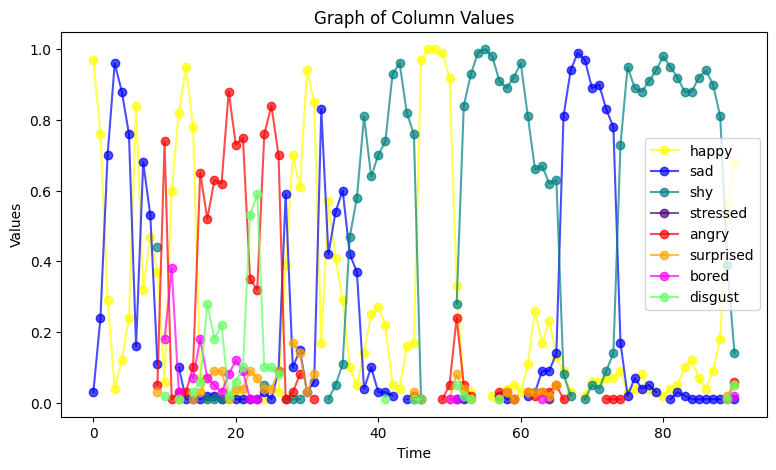

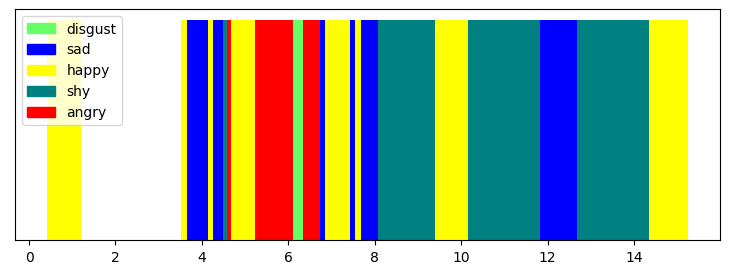

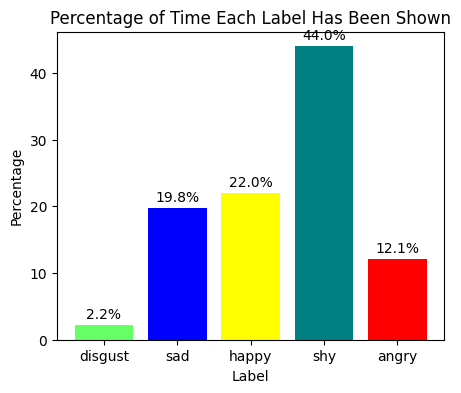

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_coords = pd.read_csv('interview_outputs/coords.csv')
df_confidence = pd.read_csv('interview_outputs/confidence.csv')
df_labels_list = df_confidence['label']
df_length = len(df_confidence)

# Select columns for analysis
selected_columns = ['happy', 'sad', 'shy', 'stressed', 'angry', 'surprised', 'bored', 'disgust']

data = pd.read_csv('interview_outputs/confidence.csv')
selected_data = data[selected_columns]

# Set the values of zero to NaN for selected_data
selected_data[selected_data == 0] = float('nan')

# Define label colors
label_colors = {
    'happy': 'yellow',
    'sad': 'blue',
    'angry': 'red',
    'stressed': 'indigo',
    'disgust': '#66FF66',
    'shy': 'teal',
    'bored': 'magenta',
    'surprised': 'orange'
}


##### 1st graph #####

# Plot graph of column values
fig, ax = plt.subplots(figsize=(len(data) * 0.1, 5))
selected_data.plot(kind='line', marker='o', alpha=0.7, ax=ax, color=[
                   label_colors[column] for column in selected_data.columns])

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Graph of Column Values')

plt.show()





##### 2nd graph #####

# Replace values
replaced_strings = [
    string for string in df_labels_list if string in selected_columns and string != 'None']

# Create a list of unique labels
unique_labels = list(set(replaced_strings))

# Assign a color to each label
label_colors = [label_colors[label] for label in unique_labels]

# Calculate the height of each column
heights = np.ones(len(replaced_strings))

# Plot the replaced strings
fig, ax = plt.subplots(figsize=(len(data['time']) * 0.1, 3))
bars = ax.bar(data['time'], heights, color=[
              label_colors[unique_labels.index(label)] for label in replaced_strings])

# Remove y-axis and tick labels
ax.get_yaxis().set_visible(False)
ax.set_yticklabels([])

# Add a legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=label_colors[i])
                  for i in range(len(unique_labels))]
ax.legend(legend_handles, unique_labels)

# Set the color cycle for the second graph
ax.set_prop_cycle(color=label_colors)

plt.show()




##### 3rd graph #####

# Calculate the percentage of time each label has been shown
label_percentages = [replaced_strings.count(
    label) / df_length * 100 for label in unique_labels]

# Plot the percentage graph
fig, ax = plt.subplots(figsize=(len(unique_labels) * 1, 4))
ax.bar(unique_labels, label_percentages, color=label_colors)

# Add labels to the bars
for i, label in enumerate(unique_labels):
    ax.text(i, label_percentages[i] + 1,
            f"{label_percentages[i]:.1f}%", ha='center')

plt.xlabel('Label')
plt.ylabel('Percentage')
plt.title('Percentage of Time Each Label Has Been Shown')
plt.show()
